# **AUDIO CLASSIFICATION**

**IMPORT LIBRARY**

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 2s 0us/step


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['go' 'down' 'yes' 'stop' 'up' 'left' 'no' 'right']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir)+ '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', 
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/eee9b9e2_nohash_1.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:6400]
val_files = filenames[6400:6400+800]
test_files = filenames[-800:]

In [6]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

**SPECTROGRAM**

In [10]:
def get_spectrogram(waveform):
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  return spectrogram

In [11]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [12]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [13]:
def plot_spectrogram(spectrogram, ax):
  log_spec = np.log( spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

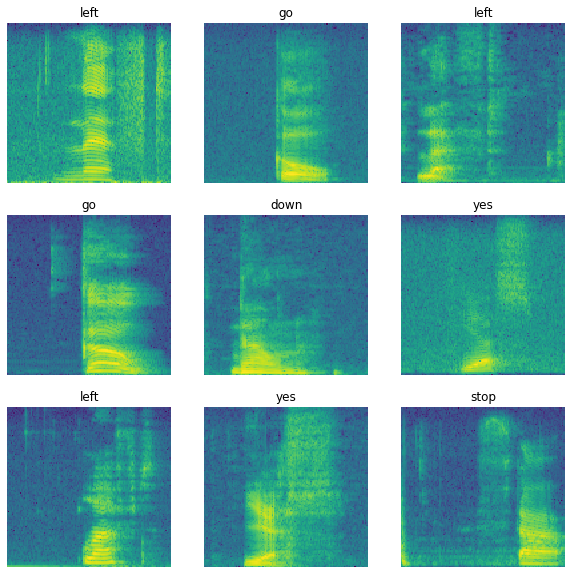

In [14]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id,
                            num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([layers.Input(shape=input_shape),
                          layers.Resizing(32, 32),
                          norm_layer,
                          layers.Conv2D(32, 3, activation='relu'),
                          layers.Conv2D(64, 3, activation='relu'),
                          layers.MaxPooling2D(),
                          layers.Dropout(0.25),
                          layers.Flatten(),
                          layers.Dense(128, activation='relu'),
                          layers.Dropout(0.5),
                          layers.Dense(num_labels)])
model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2914 - accuracy: 0.8944 - val_loss: 0.4872 - val_accuracy: 0.8350
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2649 - accuracy: 0.9058 - val_loss: 0.4662 - val_accuracy: 0.8537
Epoch 3/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2529 - accuracy: 0.9145 - val_loss: 0.4867 - val_accuracy: 0.8487
Epoch 4/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2453 - accuracy: 0.9145 - val_loss: 0.4623 - val_accuracy: 0.8562
Epoch 5/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2429 - accuracy: 0.9166 - val_loss: 0.4542 - val_accuracy: 0.8537
Epoch 6/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2269 - accuracy: 0.9214 - val_loss: 0.4794 - val_accuracy: 0.8450
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2291 - accuracy: 0.9161 - val_loss: 0.4445 - val_accuracy: 0.8512

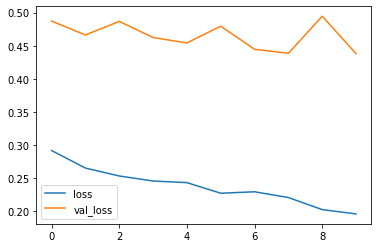

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []
for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc: .0%}')

Test set accuracy:  86%
